# Assignment: Trees

## Do two questions in total: "Q1+Q2" or "Q1+Q3"

`! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Please answer the following questions in your own words.
1. Why is the Gini a good loss function for categorical target variables? 
2. Why do trees tend to overfit, and how can this tendency be constrained? 
3. True or false, and explain: Trees only really perform well in situations with lots of categorical variables as features/covariates. 
4. Why don't most versions of classification/regression tree concept allow for more than two branches after a split?
5. What are some heuristic ways you can examine a tree and decide whether it is probably over- or under-fitting?

1. 
The Gini impurity measures how often a randomly chosen element from a set would be misclassified if it were labeled according to the distribution of classes in that set.  It's good for categorical targets because it quantifies how "mixed" or "impure" a node is where a pure node has Gini = 0, while a maximally mixed node has higher Gini.

2. 
Decision trees easily overfit because they keep splitting to perfectly fit all training points, including noise and outliers. This over-specialization reduces generalization on new data. Overfitting can be constrained by limiting tree depth, requiring a minimum number of samples per leaf node (min_samples_leaf), setting a minimum impurity decrease for a split.

3. 
False. 
Trees can actually perform well with both categorical and continuous features. They handle categorical variables by splitting on category membership, but they also handle numeric variables effectively by finding optimal thresholds. 

4. 
Most decision tree algorithms use binary splits because they are simpler to compute, easier to compare in regards od impurity reduction, and make the tree structure more interpretable while multi-way splits increase complexity exponentially and can lead to less consistent trees. 

5. Some signs of overfitting are a deep tree with many levels and underfitting would be a shallow tree. Some other factors to consider are leaf nodes where small samples per leaves suggest overfitting. Another way is through an accuracy gap

**Q3.** This is a case study about trees using bond rating data. This is a dataset about bond ratings for different companies, alongside a bunch of business statistics and other data. Companies often have multiple reviews at different dates. We want to predict the bond rating (AAA, AA, A, BBB, BB, B, ..., C, D). Do business fundamentals predict the company's rating?

1. Load the `./data/corporate_ratings.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  Plot a histogram of the `ratings` variable. It turns out that the gradations of AAA/AA/A and BBB/BB/B and so on make it hard to get good results with trees. Collapse all AAA/AA/A ratings into just A, and similarly for B and C.

3. Use all of the variables **except** Rating, Date, Name, Symbol, and Rating Agency Name. To include Sector, make a dummy/one-hot-encoded representation and include it in your features/covariates. Collect the relevant variables into a data matrix $X$. 

4. Do a train/test split of the data and use a decision tree classifier to predict the bond rating. Including a min_samples_leaf constraint can raise the accuracy and speed up computation time. Print a confusion matrix and the accuracy of your model. How well do you predict the different bond ratings?

5. If you include the rating agency as a feature/covariate/predictor variable, do the results change? How do you interpret this?

In [1]:
import pandas as pd
df = pd.read_csv('./data/corporate_ratings.csv')
print(df.shape)  # Shows (#rows, #columns)
df.head()        # Shows the first few rows


(2029, 31)


,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


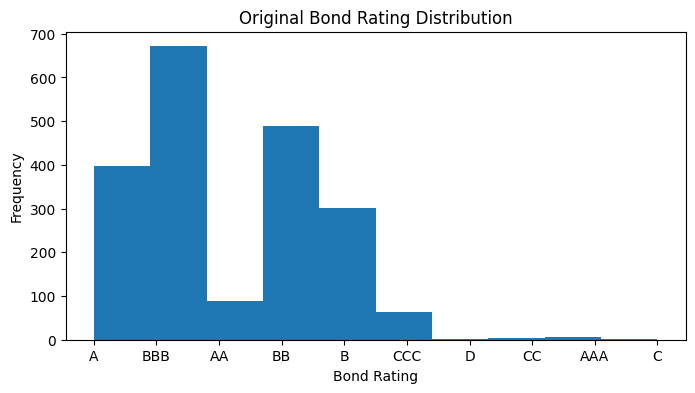

ratings_collapsed
B    1463
A     494
C      72
Name: count, dtype: int64


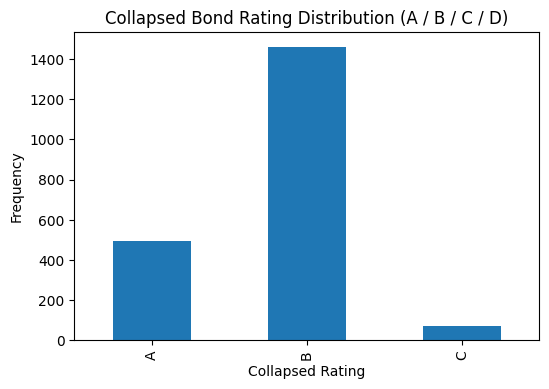

In [18]:
import matplotlib.pyplot as plt
import numpy as np

#original Ratings
plt.figure(figsize=(8,4))
plt.hist(df['Rating'], bins=len(df['Rating'].unique()))
plt.xlabel('Bond Rating')
plt.ylabel('Frequency')
plt.title('Original Bond Rating Distribution')
plt.show()

# --- Collapse Ratings into broader categories ---
def collapse_rating(r):
    if pd.isna(r):
        return np.nan
    s = str(r).upper().strip()
    # Remove + or - signs (AA-, BBB+, etc.)
    s = s.replace('+','').replace('-','')
    if s.startswith('A'):
        return 'A'
    elif s.startswith('B'):
        return 'B'
    else:
        return 'C'

df['ratings_collapsed'] = df['Rating'].apply(collapse_rating)

# Check the counts of the collapsed ratings
print(df['ratings_collapsed'].value_counts(dropna=False))

# Plot collapsed distribution
plt.figure(figsize=(6,4))
df['ratings_collapsed'].value_counts().sort_index().plot(kind='bar')
plt.title('Collapsed Bond Rating Distribution (A / B / C / D)')
plt.xlabel('Collapsed Rating')
plt.ylabel('Frequency')
plt.show()


In [32]:
#3.3 
import pandas as pd
import numpy as np

drop_cols = [
    'Rating', 'ratings_collapsed', 'Rating_collapsed',  # drop both just in case
    'Date', 'Name', 'Symbol', 'Rating Agency Name'
]
X = df.drop(columns=drop_cols, errors='ignore')


if 'Sector' in X.columns:
    X = pd.get_dummies(X, columns=['Sector'], drop_first=True)

#Ensure all Sector_* columns are numeric 0/1 (map "True"/"False" or True/False)
sector_cols = [c for c in X.columns if c.startswith('Sector_')]
for c in sector_cols:
    if X[c].dtype == 'O':  # object "True"/"False"
        X[c] = X[c].map({'True':1, 'False':0, True:1, False:0}).astype('Int8').fillna(0)
    elif X[c].dtype == 'bool':  # boolean -> cast to int
        X[c] = X[c].astype('Int8')

# 4) If non-numeric columns remain, one-hot them too
non_numeric = X.select_dtypes(exclude=['number', 'bool']).columns.tolist()
if non_numeric:
    X = pd.get_dummies(X, columns=non_numeric, drop_first=True)

#target
y = df['ratings_collapsed']

print("Non-numeric columns after fixes (should be empty):",
      X.select_dtypes(exclude=['number']).columns.tolist())
print("X shape:", X.shape, " | y shape:", y.shape)



Non-numeric columns after fixes (should be empty): []
X shape: (2029, 36)  | y shape: (2029,)


Decision Tree — Accuracy: 0.722

Classification report:
              precision    recall  f1-score   support

           A       0.50      0.41      0.45        99
           B       0.78      0.85      0.81       293
           C       0.50      0.29      0.36        14

    accuracy                           0.72       406
   macro avg       0.59      0.52      0.54       406
weighted avg       0.71      0.72      0.71       406



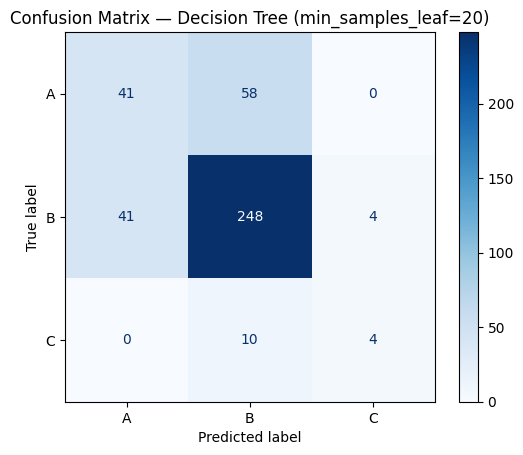

Decision Tree (with Rating Agency) — Accuracy: 0.783


In [44]:
#3.4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

#drop rows with missing target
mask = y.notna()
X_ = X.loc[mask].copy()
y_ = y.loc[mask].copy()

# Use stratify only if all classes have >= 2 samples
counts = y_.value_counts()
can_stratify = (counts >= 2).all()
if not can_stratify:
    print("Note: Not stratifying due to very rare class(es):", counts[counts < 2].to_dict())

# Train + test split
X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, test_size=0.2, random_state=104, stratify=y_ if can_stratify else None
)

# Impute any missing numerics (fit on train only)
imp = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp  = pd.DataFrame(imp.transform(X_test),  columns=X_test.columns,  index=X_test.index)

# Train a Decision Tree 
clf = DecisionTreeClassifier(
    criterion="gini",
    min_samples_leaf=20,
    random_state=104,
)
clf.fit(X_train_imp, y_train)

y_pred = clf.predict(X_test_imp)
acc = accuracy_score(y_test, y_pred)
print(f"Decision Tree — Accuracy: {acc:.3f}\n")

#ABC
labels = ["A", "B", "C"]
print("Classification report:")
print(classification_report(y_test, y_pred, labels=labels, zero_division=0))

# Confusion Matrix...fixed label order
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap="Blues")
plt.title("Confusion Matrix — Decision Tree (min_samples_leaf=20)")
plt.show()

# 3.5:

# Rebuild X to with agency
X_with_agency = df.drop(columns=['Rating','ratings_collapsed','Rating_collapsed','Date','Name','Symbol'], errors='ignore')
for col in ['Sector','Rating Agency Name']:
    if col in X_with_agency.columns:
        X_with_agency = pd.get_dummies(X_with_agency, columns=[col], drop_first=True)

# Target
y_ = df['ratings_collapsed'].dropna()
X_with_agency = X_with_agency.loc[y_.index]


X_tr, X_te, y_tr, y_te = train_test_split(X_with_agency, y_, test_size=0.2, random_state=104, stratify=y_)
imp = SimpleImputer(strategy="median")
X_tr_imp = pd.DataFrame(imp.fit_transform(X_tr), columns=X_tr.columns, index=X_tr.index)
X_te_imp  = pd.DataFrame(imp.transform(X_te),  columns=X_te.columns,  index=X_te.index)


clf_agency = DecisionTreeClassifier(criterion="gini", min_samples_leaf=20, random_state=104)
clf_agency.fit(X_tr_imp, y_tr)

# Evaluate
y_hat = clf_agency.predict(X_te_imp)
acc_agency = accuracy_score(y_te, y_hat)
print(f"Decision Tree (with Rating Agency) — Accuracy: {acc_agency:.3f}")


The decision tree model achieved an accuracy of 72.2%, showing moderate success in predicting bond ratings. It performed best on class B, which is the most common rating, but often confused A and B since their financial characteristics are similar. Overall, the model captures general credit patterns but struggles with finer distinctions between similar rating levels.

The increase in accuracy from 0.72 to 0.78 after adding Rating Agency Name as a predictor indicates that the agency provides valuable information that helps the model better predict bond ratings. This suggests that different agencies apply slightly distinct rating standards or criteria, which the model can learn to improve its predictions.